In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [55]:
df=pd.read_csv('Data\diabetes.csv')

In [56]:
df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...
99995,Female,80.0,0,0,No Info,27.32,6.2,90,0
99996,Female,2.0,0,0,No Info,17.37,6.5,100,0
99997,Male,66.0,0,0,former,27.83,5.7,155,0
99998,Female,24.0,0,0,never,35.42,4.0,100,0


In [60]:
df['smoking_history'].unique()

array(['never', 'No Info', 'current', 'former', 'ever', 'not current'],
      dtype=object)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [31]:
print(df.duplicated())
print(df.duplicated().sum())

0        False
1        False
2        False
3        False
4        False
         ...  
99995     True
99996    False
99997    False
99998    False
99999    False
Length: 100000, dtype: bool
3854


In [32]:
df.drop_duplicates(inplace=True)

In [33]:
df.duplicated().sum()

0

In [34]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [35]:
df.describe(include='object')

,gender,smoking_history
count,96146,96146
unique,3,6
top,Female,never
freq,56161,34398


In [36]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000,96146.000000
mean,41.794326,0.077601,0.040803,27.321461,5.532609,138.218231,0.088220
std,22.462948,0.267544,0.197833,6.767716,1.073232,40.909771,0.283616
min,0.080000,0.000000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.000000,0.000000,23.400000,4.800000,100.000000,0.000000
50%,43.000000,0.000000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,59.000000,0.000000,0.000000,29.860000,6.200000,159.000000,0.000000
max,80.000000,1.000000,1.000000,95.690000,9.000000,300.000000,1.000000


In [37]:
numeric_col=[]
non_numeric_col=[]
for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        if(df[column].nunique()<5):
            non_numeric_col.append(column)
        else:
            numeric_col.append(column)
    else:
        non_numeric_col.append(column)

In [38]:
print(numeric_col)
print(non_numeric_col)

['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
['gender', 'hypertension', 'heart_disease', 'smoking_history', 'diabetes']


In [39]:
def univariate_analysis_numeric(col):
    fig, ax = plt.subplots(1, 2, figsize=(12,10))    
    sns.histplot(x=df[col], kde=True, bins=20, color='skyblue',ax=ax[0])
    ax[0].set_title(f'Histogram of {col}.')
    
    sns.boxplot(x=df[col],ax=ax[1])
    ax[1].set_title(f'Boxplot diagram of {col}     ')

 Univariate analysis for age column:
 Univariate analysis for bmi column:
 Univariate analysis for HbA1c_level column:
 Univariate analysis for blood_glucose_level column:


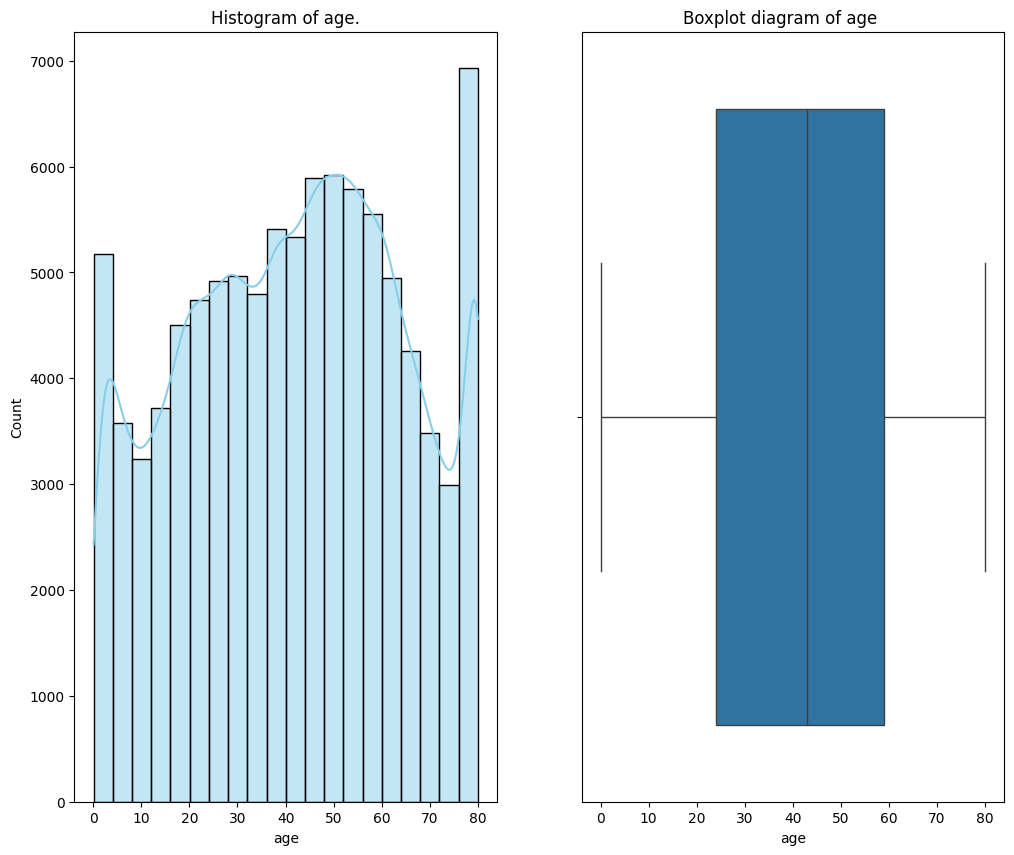

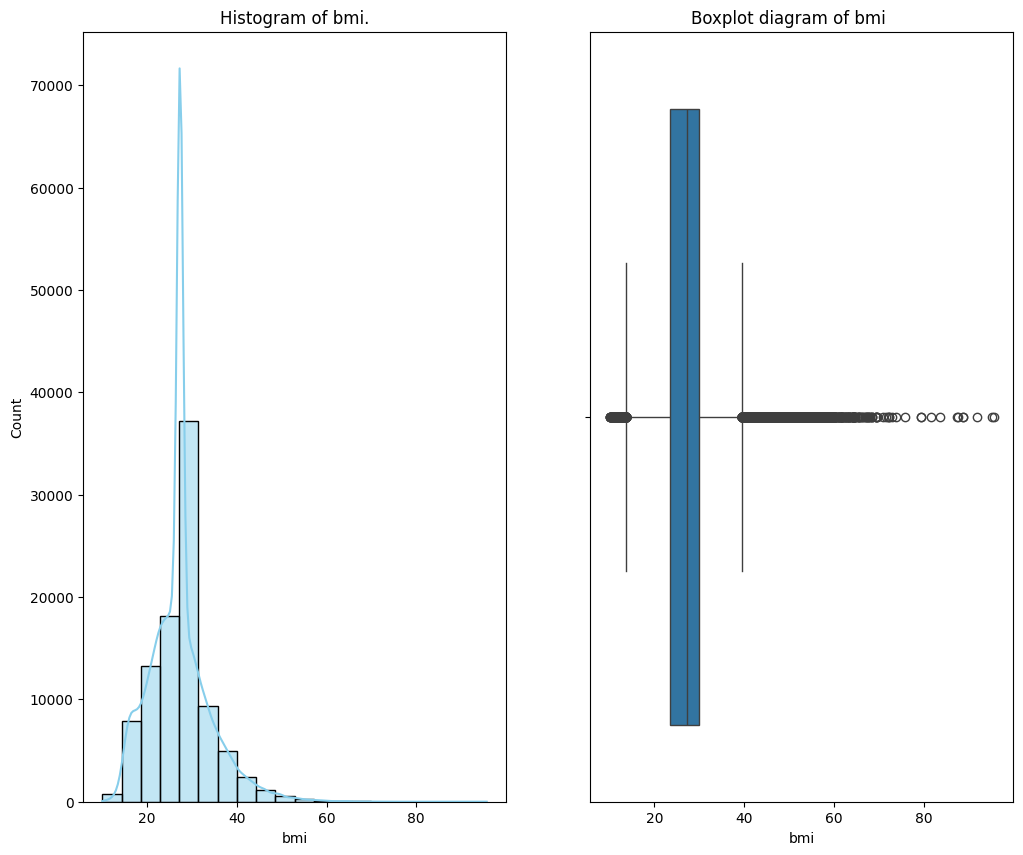

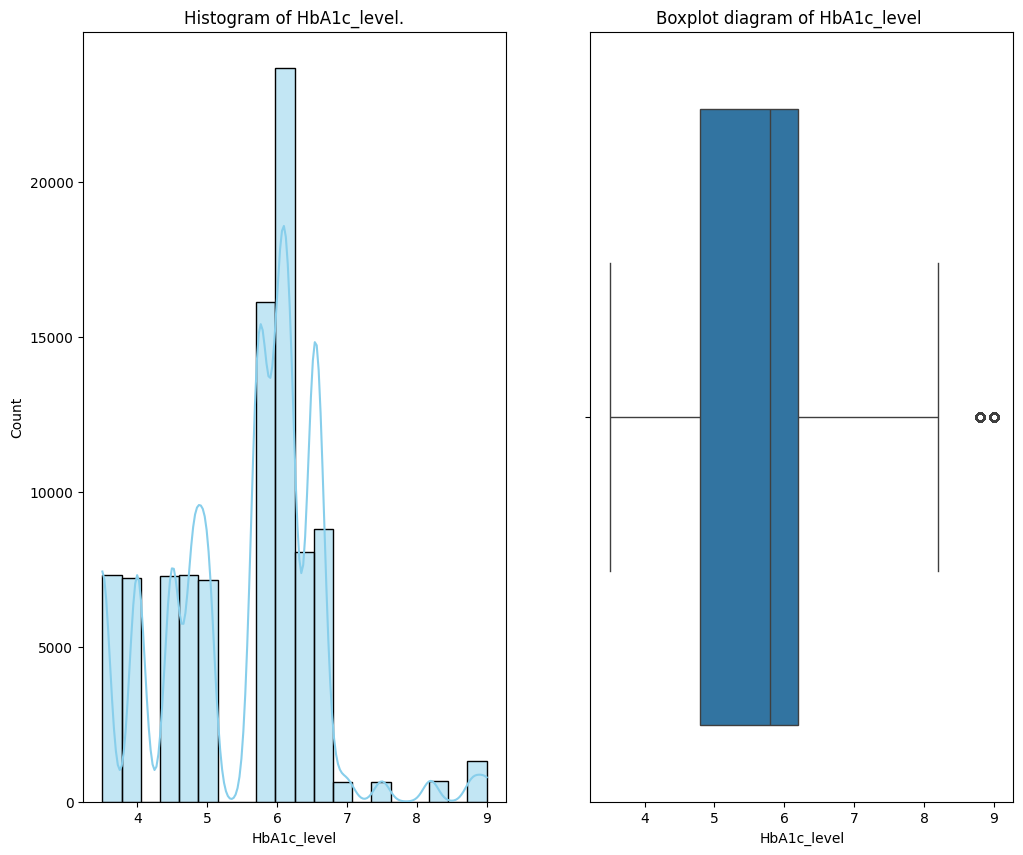

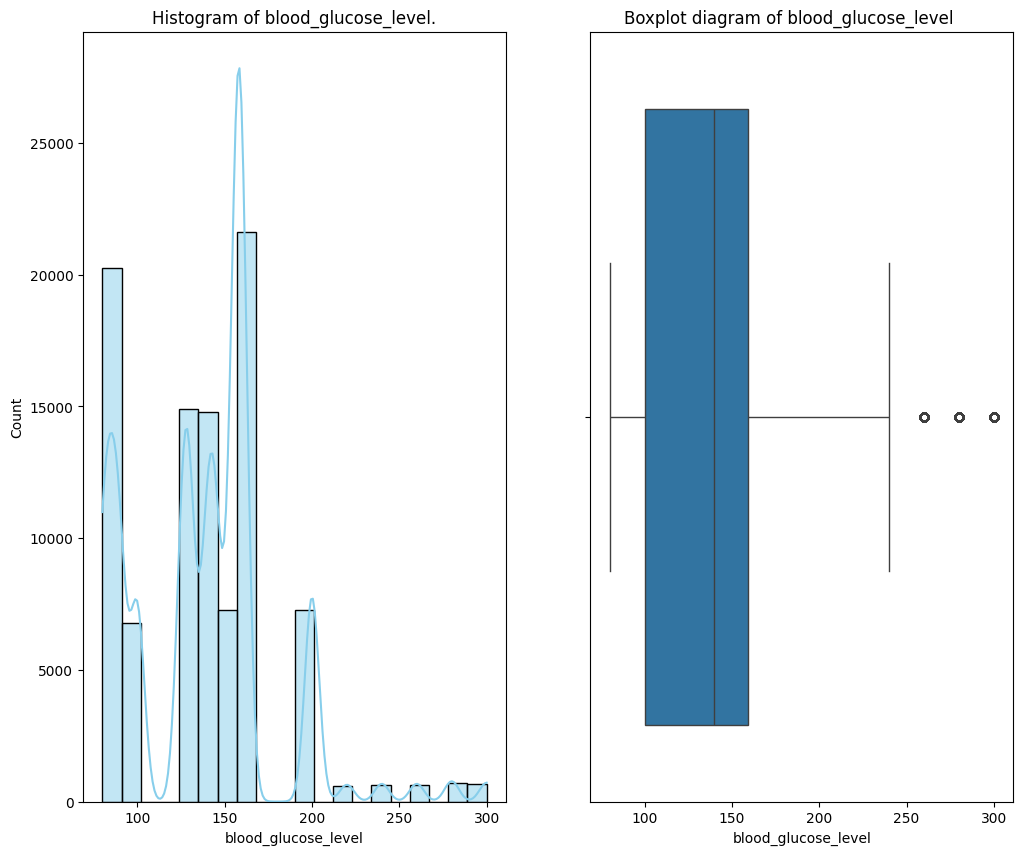

In [40]:
for col in numeric_col:
    print(f' Univariate analysis for {col} column:')
    univariate_analysis_numeric(col)

In [41]:
def univariate_analysis_cat(col):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    # Countplot
    sns.countplot(x=df[col],data=df ,palette='viridis', ax=ax[0])
    ax[0].set_title(f'Countplot for {col}')
    
    # Pie plot
    data_counts = df[col].value_counts()
    ax[1].pie(data_counts, labels=data_counts.index, autopct='%1.3f%%', startangle=90, colors=sns.color_palette('pastel'))
    ax[1].set_title(f'Pie plot for {col}')
    
    plt.show()

 Univariate analysis for gender column:


C:\Users\KALYAN\AppData\Local\Temp\ipykernel_16428\3600597884.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col],data=df ,palette='viridis', ax=ax[0])


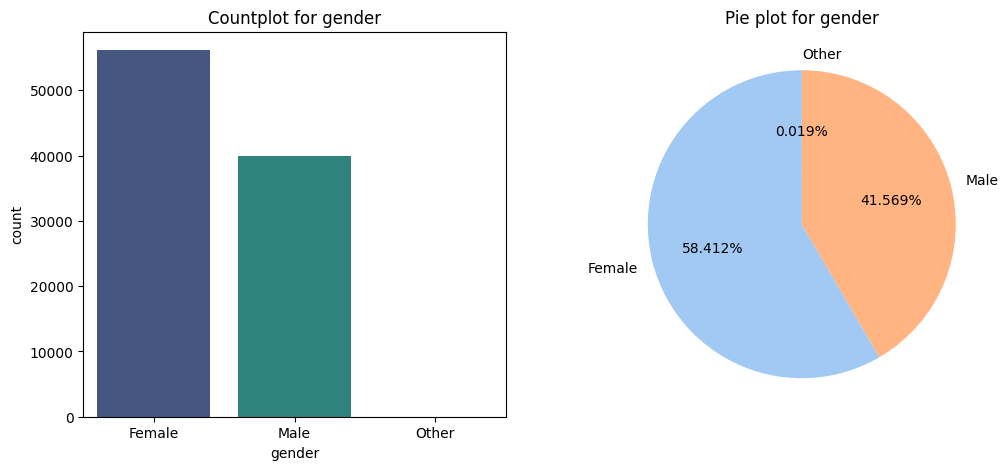

 Univariate analysis for hypertension column:


C:\Users\KALYAN\AppData\Local\Temp\ipykernel_16428\3600597884.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col],data=df ,palette='viridis', ax=ax[0])


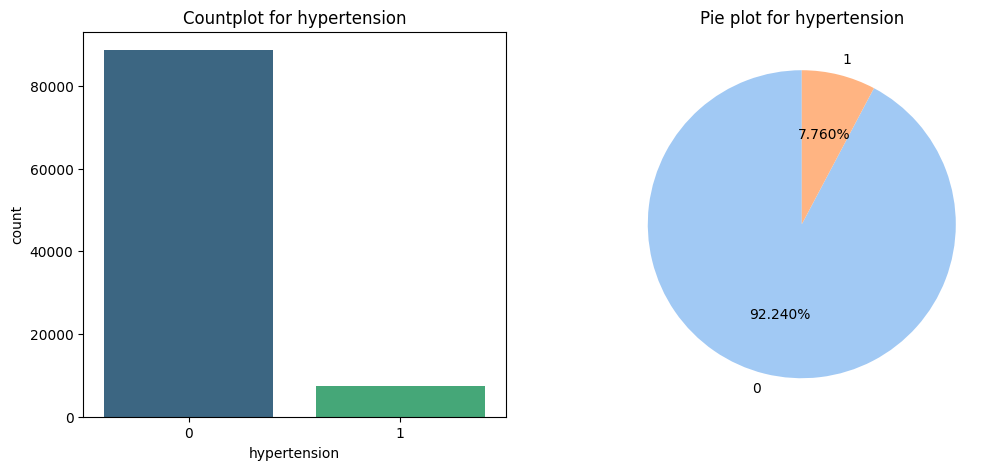

 Univariate analysis for heart_disease column:


C:\Users\KALYAN\AppData\Local\Temp\ipykernel_16428\3600597884.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col],data=df ,palette='viridis', ax=ax[0])


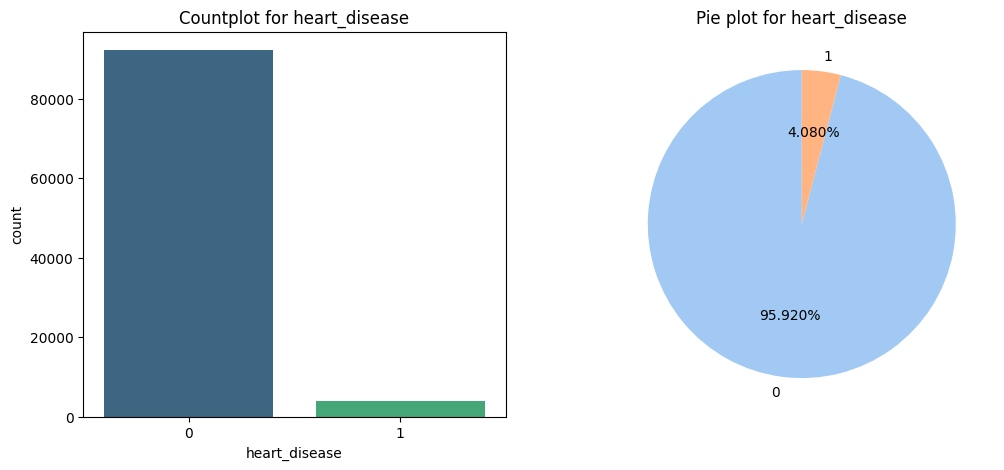

 Univariate analysis for smoking_history column:


C:\Users\KALYAN\AppData\Local\Temp\ipykernel_16428\3600597884.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col],data=df ,palette='viridis', ax=ax[0])


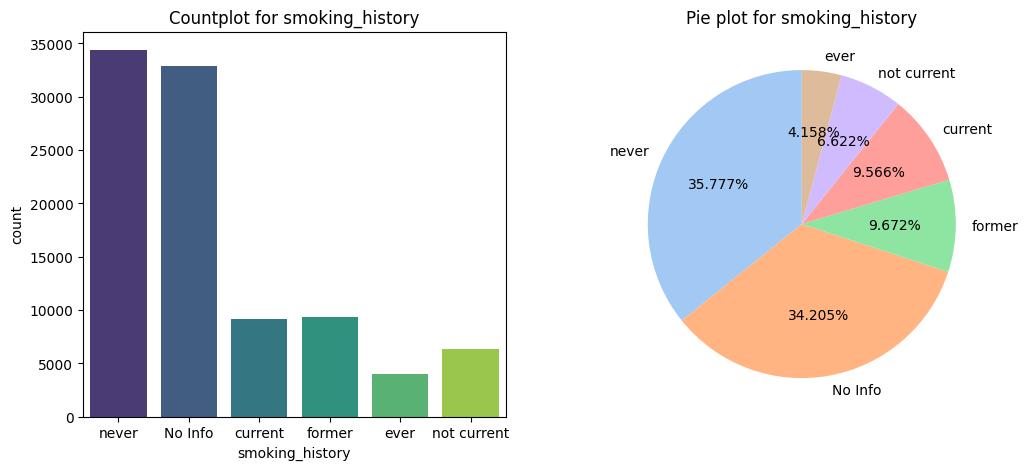

 Univariate analysis for diabetes column:


C:\Users\KALYAN\AppData\Local\Temp\ipykernel_16428\3600597884.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col],data=df ,palette='viridis', ax=ax[0])


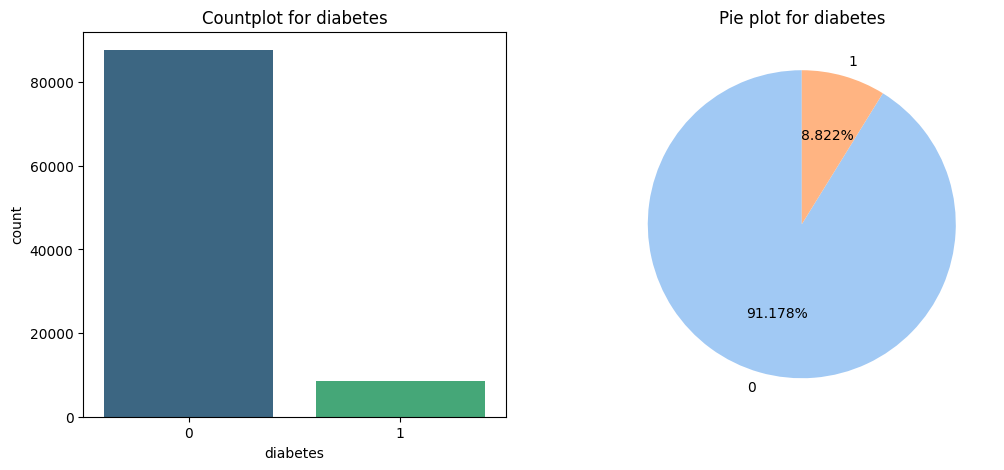

In [42]:
for col in non_numeric_col:
    print(f' Univariate analysis for {col} column:')
    univariate_analysis_cat(col)

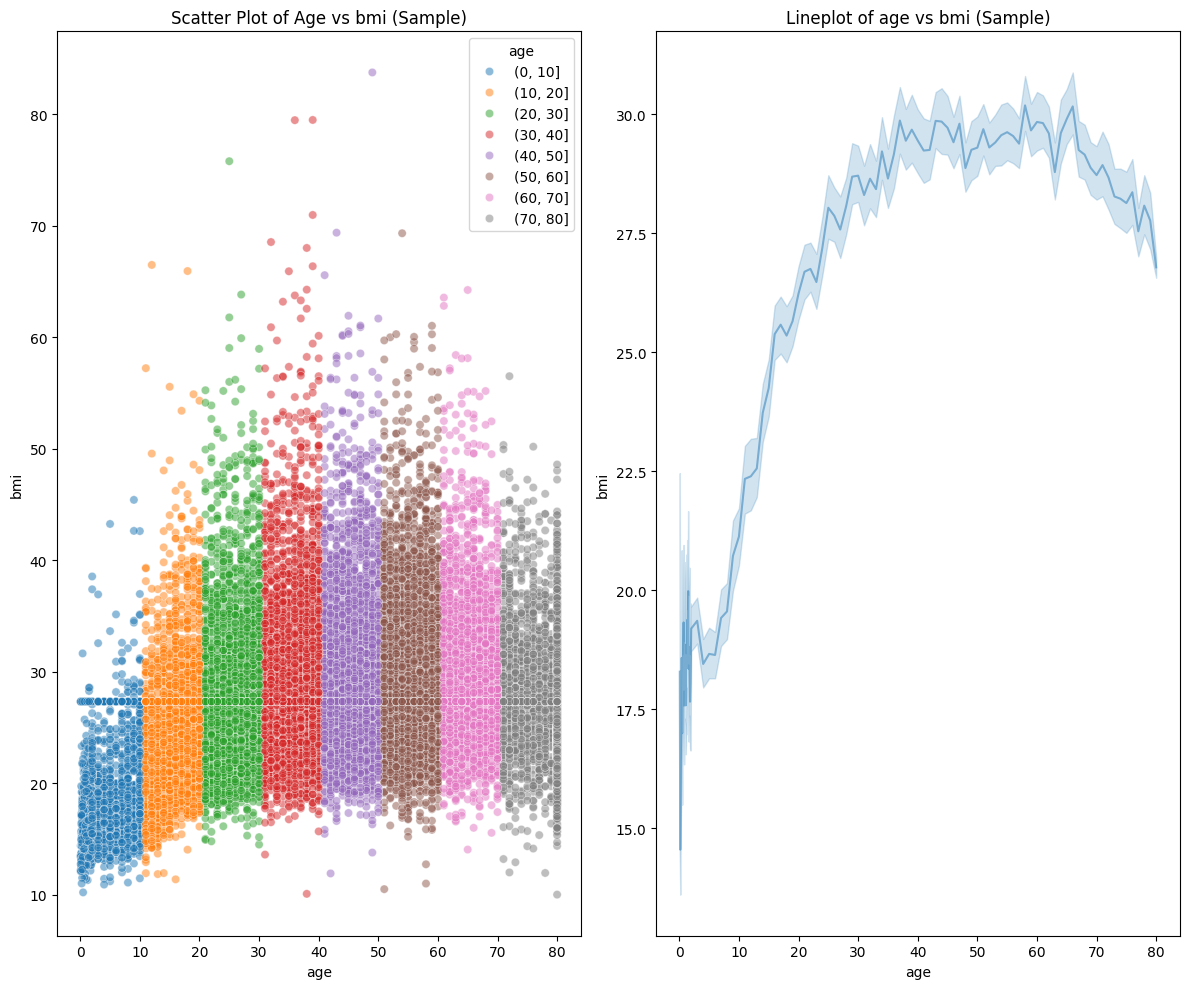

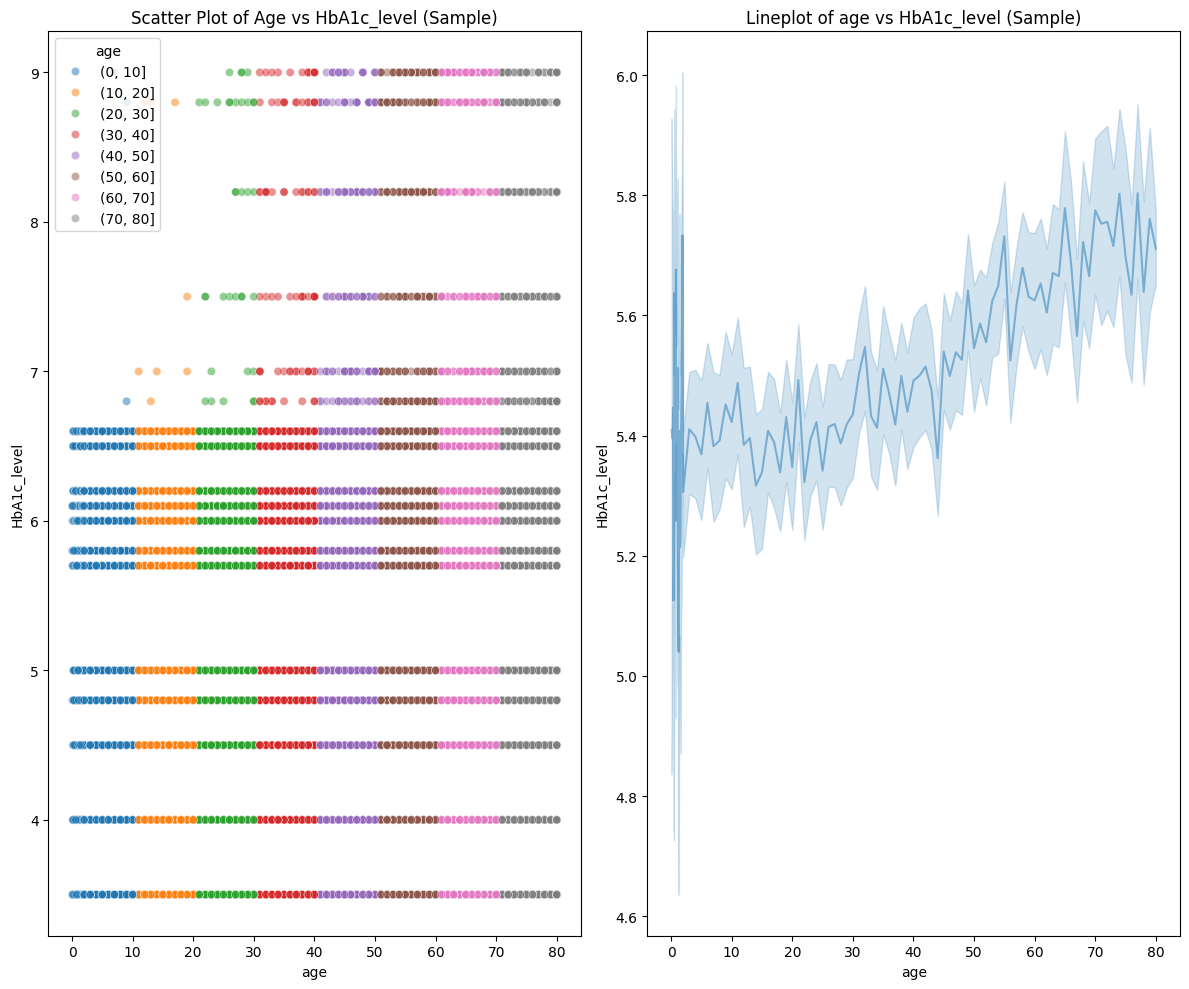

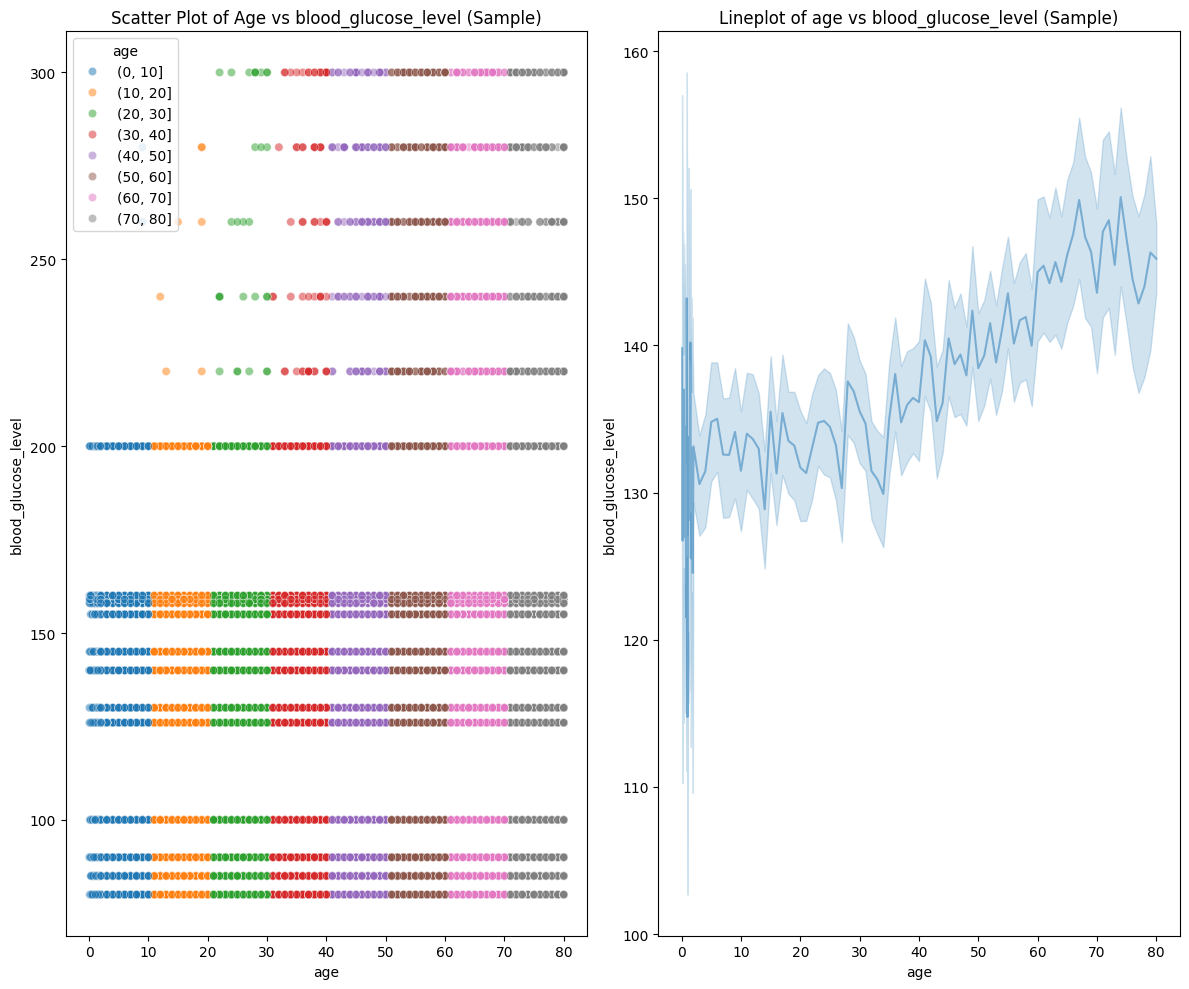

In [43]:
sample_size = 30000  
sample_df = df.sample(n=sample_size, random_state=42) 
age_group = pd.cut(df['age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80])

for col in numeric_col[1:]:
    fig, ax = plt.subplots(1, 2, figsize=(12, 10))
    sns.scatterplot(x='age', y=df[col], data=sample_df,hue=age_group, alpha=0.5,ax=ax[0])
    ax[0].set_title(f'Scatter Plot of Age vs {col} (Sample)')
    
    sns.lineplot(x='age',y=df[col],data=sample_df,alpha=0.5,ax=ax[1])
    ax[1].set_title(f'Lineplot of age vs {col} (Sample)')
    plt.tight_layout()
    plt.show()

In [44]:
print(sample_df['age'].mean())
print(df['age'].mean())

41.85690399999999
41.79432571297817


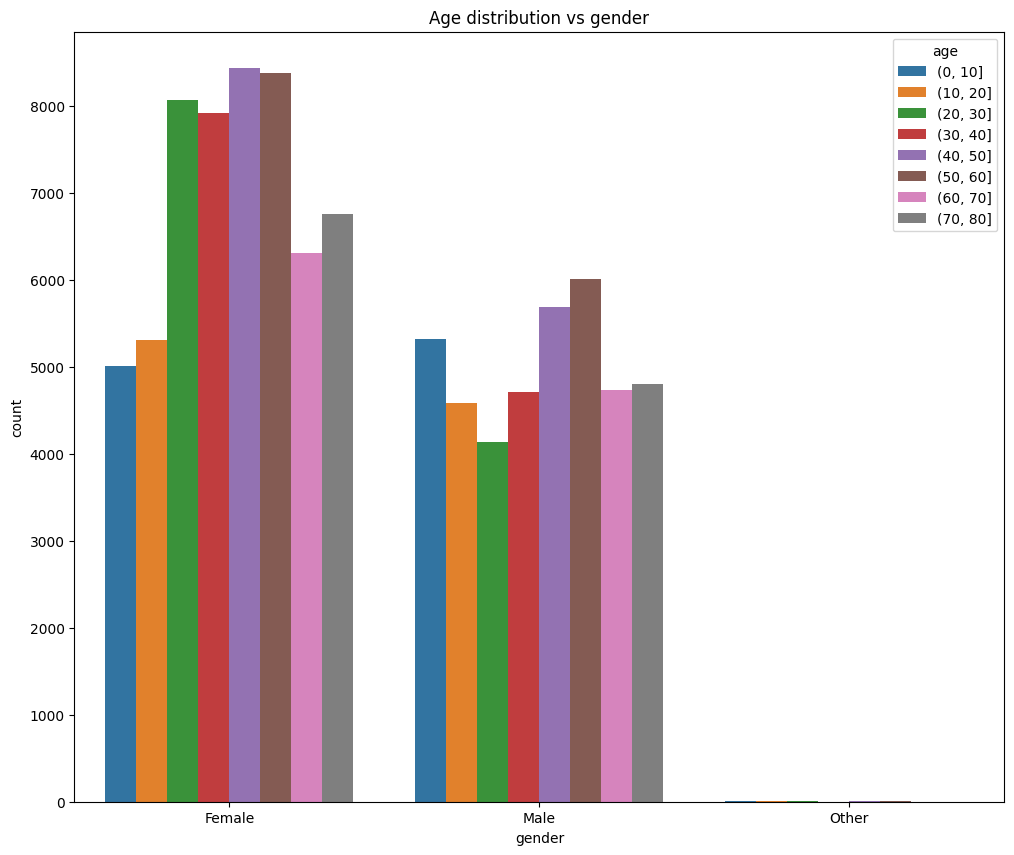

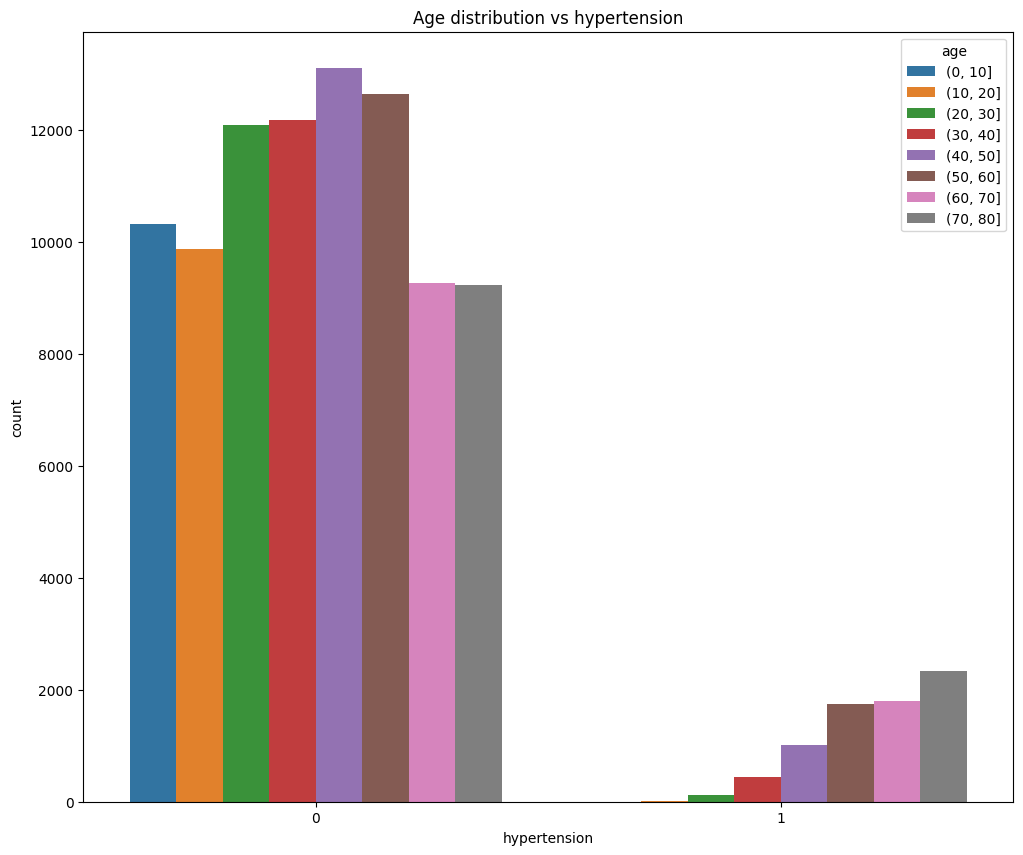

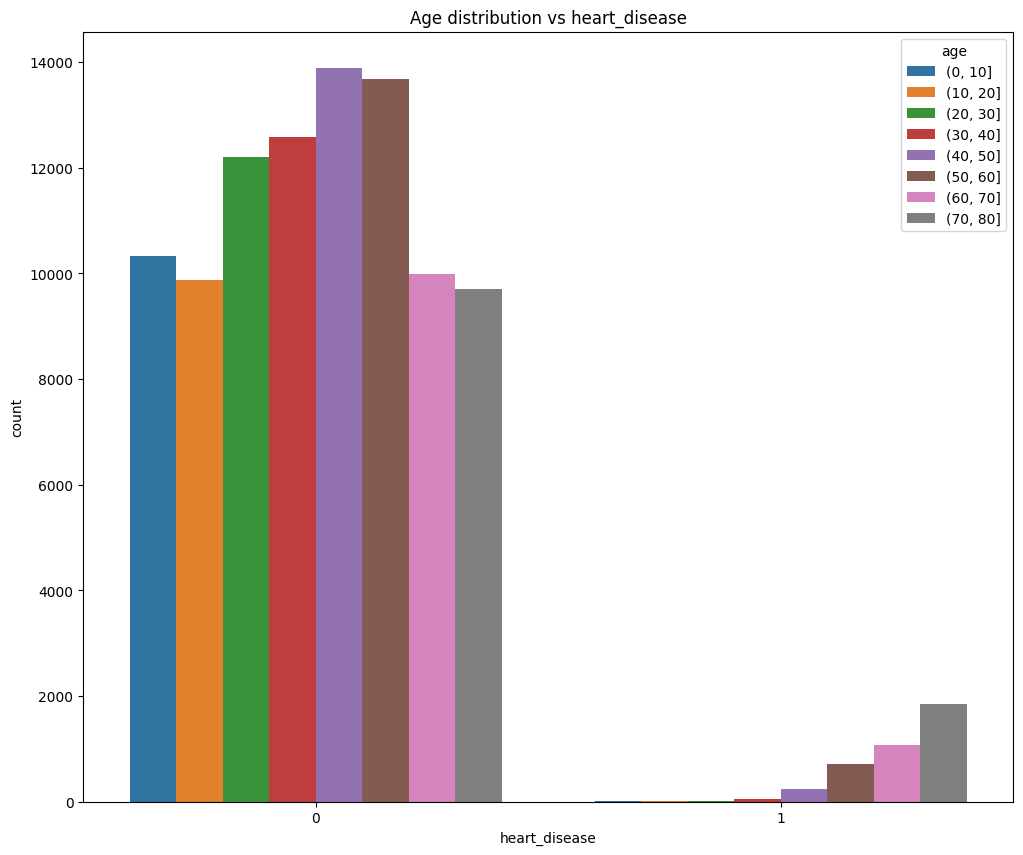

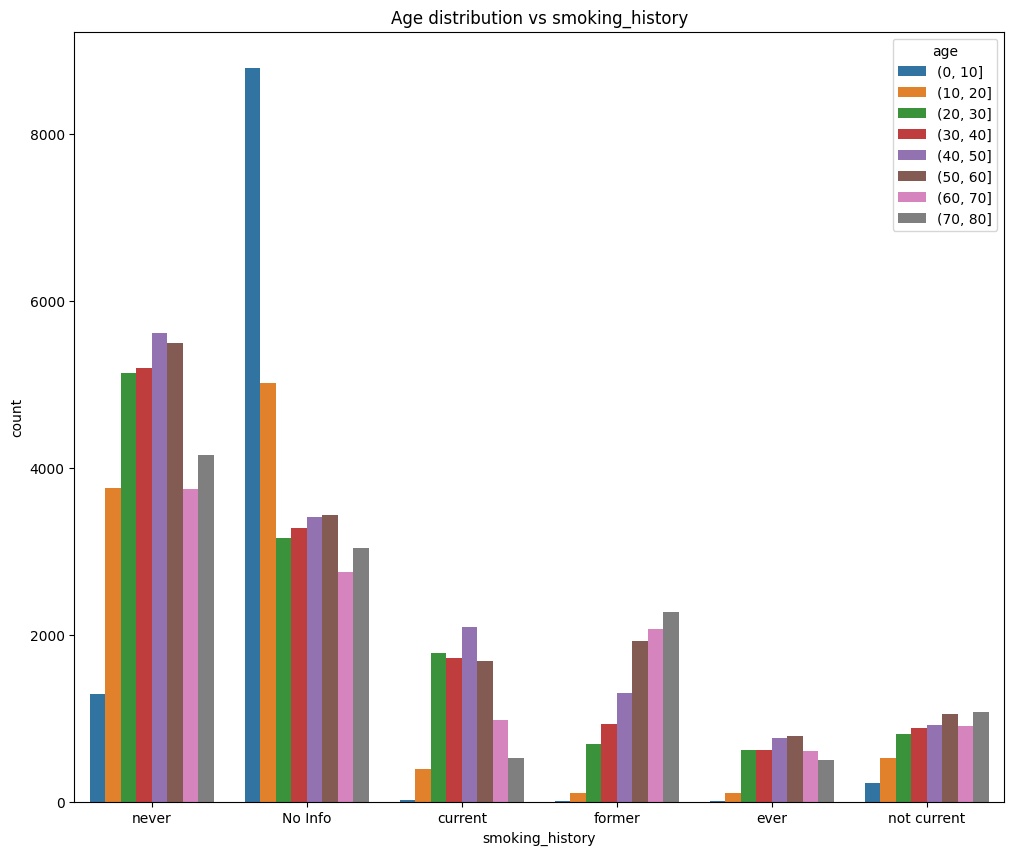

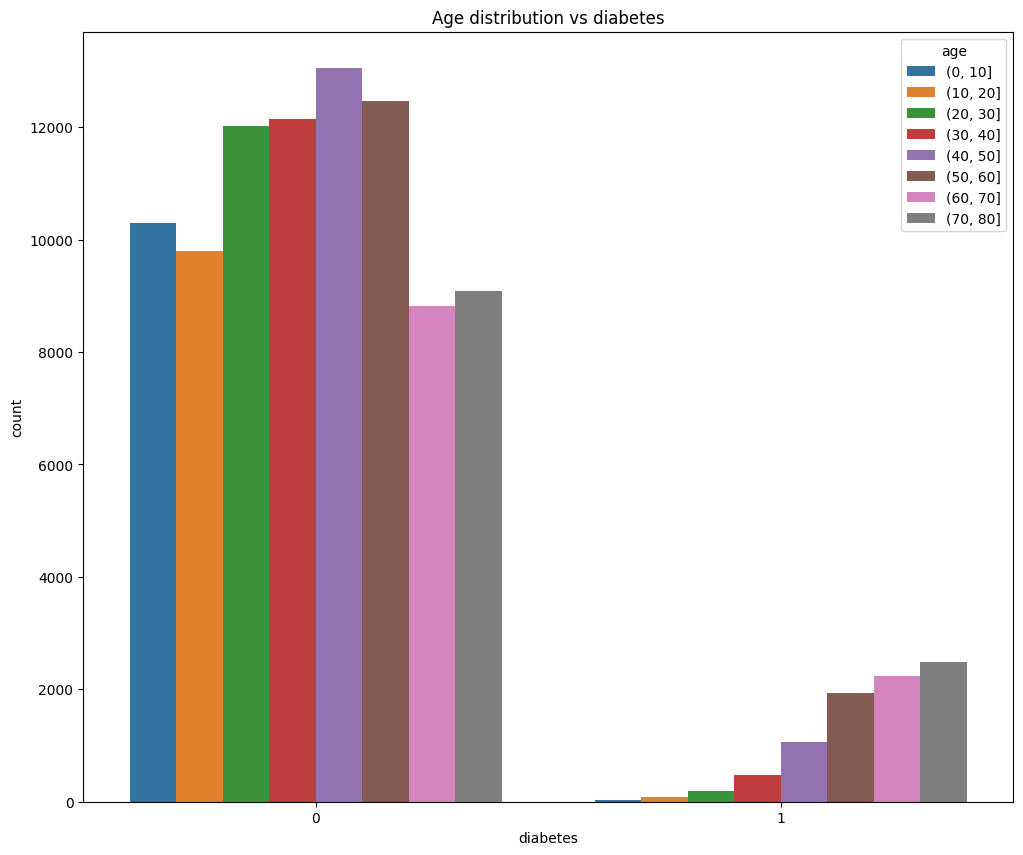

In [45]:
age_group = pd.cut(df['age'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80])
for i in non_numeric_col:
    plt.figure(figsize=(12,10))
    sns.countplot(x=df[i],data=df,hue=age_group)
    plt.title(f'Age distribution vs {i}')
    plt.show()


In [46]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for col in non_numeric_col:
    sample_df[col]=le.fit_transform(sample_df[col])
sample_df

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
2547,0,5.0,0,0,0,15.14,4.5,90,0
34774,1,19.0,0,0,4,22.74,6.6,85,0
71084,0,52.0,0,0,4,24.27,7.5,220,1
50584,1,55.0,0,0,0,27.32,5.7,85,0
80788,0,22.0,0,0,4,28.78,4.5,200,0
...,...,...,...,...,...,...,...,...,...
54431,0,26.0,0,0,3,28.27,6.2,100,0
55182,0,57.0,0,0,4,22.12,5.0,100,0
92776,1,74.0,0,1,2,29.83,4.8,160,0
76035,0,11.0,0,0,0,27.32,6.2,90,0


In [47]:
x = sample_df.drop('diabetes', axis=1)
y = sample_df['diabetes']


In [53]:
x['gender'].unique()

array([0, 1, 2])

In [48]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
model_svm = SVC(kernel = 'linear', random_state = 0)
model_svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=0)

In [49]:
y_pred = model_svm.predict(X_test)

In [50]:
accuracy_svm = accuracy_score(y_test, y_pred)
print(accuracy_svm)

0.9563333333333334


In [51]:
classification_rep_svm = classification_report(y_test, y_pred)
print(classification_rep_svm)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      8151
           1       0.93      0.58      0.72       849

    accuracy                           0.96      9000
   macro avg       0.94      0.79      0.85      9000
weighted avg       0.96      0.96      0.95      9000

